#### Créations des descripteurs de chaque image
1. Pour chaque image passage en gris et equalisation

2. création d'une liste de descripteurs par image ("sift_keyspoints_img") qui sera utilisée pour réaliser les histogrammes par image

3. création d'une liste de descripteurs pour l'ensemble des images ("sift_keyspoints_all_imag") qui sera utilisé pour créer les clusters de descripteurs (on vera çe on détaille  aprés)

In [1]:
from os import getcwd
import pandas as pd
import numpy as np 
import sys
sys.path.append("C:\\Users\\User\\WORK\\workspace-ia\\PERSO\\")
from ara_commons import ara_picture_function as ara_pict
from ara_commons.ara_file import get_dir_files
import matplotlib.pyplot as plt

In [2]:
# ---------------------------------------------------------------------------------------------
#                               MAIN
# ---------------------------------------------------------------------------------------------
verbose = False
force_reloading = True

# Récupère le répertoire du programme
file_path = getcwd() + "\\"
file_path

'c:\\Users\\User\\WORK\\workspace-ia\\simplon\\2022-03-Images\\'

In [3]:
img_cloudy_path = file_path + "cloudy10.jpg"
img_zack_path = file_path + "20210925_190551.jpg"

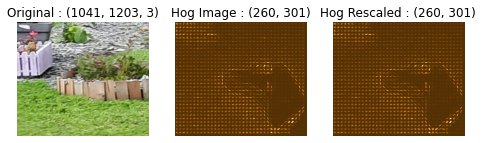

In [4]:
img_zack, resized_img_zack, hog_image_zack = ara_pict.show_hog(img_path=img_zack_path, reduce_ratio=4)

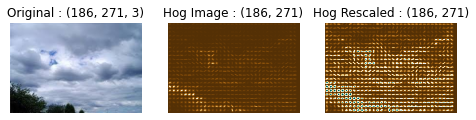

In [5]:
img_cloudy, resized_img_cloudy, hog_image_cloudy = ara_pict.show_hog(img_path=img_cloudy_path)

In [6]:
source_data_path = file_path+"dataset\\"
print("Source path :", source_data_path)

Source path : c:\Users\User\WORK\workspace-ia\simplon\2022-03-Images\dataset\


In [7]:
# récupération données
img_extensions = [".jpg", ".jpeg", ".png"]
images = []

for ext in img_extensions:
    images.extend(get_dir_files(source_data_path, endwith=ext))

print(len(images), "images")

400 images


In [8]:
from collections import defaultdict
import re

## Extract keypoints from each image

In [9]:
img_dic = defaultdict(list)
sift_keyspoints_img=[]
sift_keyspoints_all_img = []

pattern = ara_pict.get_regex_alphabetique_simple()

for img_path in images:
    try:
        img_dic["file_name"].append(img_path)
        name = img_path.lower().split(".")[0]
        name = re.sub(pattern, '', name).strip()
        img_dic["y"].append(name)
        grayimage, keypoint, descriptor = ara_pict.define_img_point(source_data_path+img_path, nb_features=100, display=False, verbose=verbose)
        sift_keyspoints_img.append(descriptor)
        sift_keyspoints_all_img.extend(descriptor)
    except Exception as error:
        print("ERROR : ", img_path)
        print(error)
    

In [10]:
print(len(sift_keyspoints_all_img), len(sift_keyspoints_all_img[0]))

38989 128


In [11]:
df_origin = pd.DataFrame.from_dict(img_dic)
print(df_origin.shape)
df_origin.columns

(400, 2)


Index(['file_name', 'y'], dtype='object')

In [12]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.neural_network import MLPClassifier

# Clustering

We now have an array with a huge number of descriptors. We cannot use all of them to create or model so we need to cluster them. A rule-of-thumb is to create k centers with k = number of categories * 10 (in our case, it's 990).


In [13]:
species = df_origin["y"].sort_values().unique()
species

array(['cloudy', 'rain', 'shine', 'sunrise'], dtype=object)

In [14]:
df_origin["y"].sort_values().nunique()

4

In [15]:
np.size(species)

4

In [16]:
# ou sqrt(len(nbrs_descripteurs))
n_clusters=df_origin["y"].sort_values().nunique() * 100
n_clusters

400

## Création des clusters de descripteurs (je vous laisse creuser un peu)
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [17]:
len(sift_keyspoints_all_img)

38989

In [18]:
batch_size = len(images) * 3
kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size, verbose=verbose).fit(sift_keyspoints_all_img)

## Creation of the histograms

To create our each image by a histogram. We will create a vector of k value for each image. For each keypoints in an image, we will find the nearest center and increase by one its value.


In [19]:
histo_list = []

for img_path in images:
    try:
        histo = np.zeros(n_clusters)
        grayimage, keypoint, descriptor = ara_pict.define_img_point(source_data_path+img_path, nb_features=100, display=False, verbose=verbose)
        nkp = np.size(keypoint)
        
        for d in descriptor:
            idx = kmeans.predict([d])
            histo[idx] += 1/nkp # Because we need normalized histograms, I prefere to add 1/nkp directly

        histo_list.append(histo)
        # sift_keyspoints_all_img_set |= set(descriptor)
    except Exception as error:
        print("ERROR : ", img_path)
        print(error)

## Training of the neural network

In [20]:
type(species)

numpy.ndarray

In [21]:
X = np.array(histo_list)
Y = []

# It's a way to convert species name into an integer
for s in df_origin["y"].to_list():
    
    Y.append(np.min(np.nonzero(species == s)))

mlp = MLPClassifier(verbose=verbose, max_iter=600000)
mlp.fit(X, Y)

MLPClassifier(max_iter=600000)

In [22]:
mlp.score(X, Y)

1.0

## Predictions

In [23]:
import csv

In [24]:
def predict(img_path, n_clusters, kmeans, mlp):
    _, keypoint, descriptor = ara_pict.define_img_point(img_path, nb_features=100, display=False, verbose=verbose)

    x = np.zeros(n_clusters)
    nkp = np.size(keypoint)

    for d in descriptor:
        idx = kmeans.predict([d])
        x[idx] += 1/nkp
    
    res = mlp.predict_proba([x])
    return res

In [25]:
result_file = open(source_data_path+ "predict3.csv", "w")
result_file_obj = csv.writer(result_file)
result_file_obj.writerow(np.append("id", species))

for img_path in images:
    try:
        res = predict(source_data_path+ img_path, n_clusters, kmeans, mlp)
        row = []
        row.append(img_path)

        for e in res[0]:
            row.append(e)

        result_file_obj.writerow(row)

    except Exception as error:
        print("ERROR : ", img_path)
        print(error)

result_file.close()

In [29]:
source_data_test_path = source_data_path.replace("dataset", "dataset_test")

# récupération données
images_test = []

for ext in img_extensions:
    images_test.extend(get_dir_files(source_data_test_path, endwith=ext))

print(len(images_test), "images")

62 images


In [30]:
images_test

['cloudy002.jpg',
 'cloudy003.jpg',
 'cloudy004.jpg',
 'cloudy005.jpg',
 'cloudy006.jpg',
 'cloudy007.jpg',
 'cloudy008.jpg',
 'cloudy009.jpg',
 'cloudy010.jpg',
 'cloudy011.jpg',
 'cloudy012.jpg',
 'cloudy013.jpg',
 'cloudy014.jpg',
 'cloudy015.jpg',
 'rain001.jpg',
 'rain003.jpg',
 'rain004.jpg',
 'rain005.jpg',
 'rain006.jpg',
 'rain007.jpg',
 'rain008.jpg',
 'rain009.jpg',
 'rain010.jpg',
 'rain011.jpg',
 'rain012.jpg',
 'rain013.jpg',
 'rain014.jpg',
 'rain015.jpg',
 'shine001.jpg',
 'shine002.jpg',
 'shine003.jpg',
 'shine004.jpg',
 'shine005.jpg',
 'shine006.jpg',
 'shine007.jpg',
 'shine008.jpg',
 'shine009.jpg',
 'shine010.jpg',
 'shine011.jpg',
 'shine012.jpg',
 'shine013.jpg',
 'shine014.jpg',
 'shine015.jpg',
 'sunrise001.jpg',
 'sunrise002.jpg',
 'sunrise003.jpg',
 'sunrise004.jpg',
 'sunrise005.jpg',
 'sunrise007.jpg',
 'sunrise008.jpg',
 'sunrise009.jpg',
 'sunrise010.jpg',
 'sunrise011.jpg',
 'sunrise012.jpg',
 'sunrise013.jpg',
 'sunrise014.jpg',
 'sunrise015.jpg',
 's

In [32]:
histo_list_test = []

for img_path in images_test:
    try:
        histo = np.zeros(n_clusters)
        grayimage, keypoint, descriptor = ara_pict.define_img_point(source_data_path+img_path, nb_features=100, display=False, verbose=verbose)
        nkp = np.size(keypoint)
        
        for d in descriptor:
            idx = kmeans.predict([d])
            histo_list_test[idx] += 1/nkp # Because we need normalized histograms, I prefere to add 1/nkp directly

        histo_list.append(histo)
        # sift_keyspoints_all_img_set |= set(descriptor)
    except Exception as error:
        print("ERROR : ", img_path)
        print(error)

KeyboardInterrupt: 

In [43]:
excpected_dic = {}
excpected_list = []
obtain_dic = {}
obtain_list = []
Y_test = []
diff_predict = {}
# X_test = np.array(histo_list_test)

if verbose: print("NAME    ", species)

for img_path in images_test:
    r = -1
    name = img_path.lower().split(".")[0]
    name = re.sub(pattern, '', name).strip()
    excpected_dic[img_path] = name
    excpected_list.append(name)
    Y_test.append(np.min(np.nonzero(species == name)))
    
    res = predict(source_data_test_path+ img_path, n_clusters, kmeans, mlp)
    res2 = res[0]

    max_item = max(res2)
    
    pre = species[np.where(res2 == max_item)][0]
    obtain_dic[img_path] = pre
    obtain_list.append(pre)

    if pre not in name:
        diff_predict[img_path] = [name, pre]

    cloud = round(res2[0],2)    
    rain = round(res2[1],2)
    shine = round(res2[2],2)
    sunrise = round(res2[3],2)

    if verbose:
        print(img_path, cloud, rain,shine, sunrise)

In [41]:
print(f"{len(diff_predict)} sur {len(images_test)}")

36 sur 62


In [40]:
diff_predict

{'cloudy002.jpg': ['cloudy', 'shine'],
 'cloudy004.jpg': ['cloudy', 'rain'],
 'cloudy006.jpg': ['cloudy', 'rain'],
 'cloudy007.jpg': ['cloudy', 'shine'],
 'cloudy009.jpg': ['cloudy', 'sunrise'],
 'cloudy011.jpg': ['cloudy', 'sunrise'],
 'rain001.jpg': ['rain', 'sunrise'],
 'rain008.jpg': ['rain', 'sunrise'],
 'rain010.jpg': ['rain', 'sunrise'],
 'rain011.jpg': ['rain', 'sunrise'],
 'rain015.jpg': ['rain', 'shine'],
 'shine001.jpg': ['shine', 'cloudy'],
 'shine002.jpg': ['shine', 'sunrise'],
 'shine004.jpg': ['shine', 'rain'],
 'shine005.jpg': ['shine', 'sunrise'],
 'shine006.jpg': ['shine', 'sunrise'],
 'shine007.jpg': ['shine', 'sunrise'],
 'shine008.jpg': ['shine', 'cloudy'],
 'shine009.jpg': ['shine', 'cloudy'],
 'shine011.jpg': ['shine', 'cloudy'],
 'shine012.jpg': ['shine', 'sunrise'],
 'shine013.jpg': ['shine', 'cloudy'],
 'shine014.jpg': ['shine', 'sunrise'],
 'shine015.jpg': ['shine', 'cloudy'],
 'sunrise001.jpg': ['sunrise', 'cloudy'],
 'sunrise002.jpg': ['sunrise', 'cloudy'],

In [44]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
import seaborn as sns


In [47]:
species

array(['cloudy', 'rain', 'shine', 'sunrise'], dtype=object)

In [51]:
excpected_list[0:5]

['cloudy', 'cloudy', 'cloudy', 'cloudy', 'cloudy']

In [52]:
obtain_list[0:5]

['shine', 'cloudy', 'rain', 'cloudy', 'rain']

In [53]:
cf_m = confusion_matrix(excpected_list, obtain_list)
cf_m

array([[ 8,  2,  2,  3],
       [ 0, 10,  1,  5],
       [ 6,  1,  2,  6],
       [ 3,  5,  2,  6]], dtype=int64)

In [54]:
df_confusion = pd.DataFrame(cf_m)
df_confusion

,0,1,2,3
0,8,2,2,3
1,0,10,1,5
2,6,1,2,6
3,3,5,2,6


In [56]:
df_confusion["expected"] = ""
for i in range(0, 4):
    df_confusion.loc[i,"expected"] = species[i]
    df_confusion = df_confusion.rename(columns={i:species[i]})

df_confusion

,cloudy,rain,shine,sunrise,expected
0,8,2,2,3,cloudy
1,0,10,1,5,rain
2,6,1,2,6,shine
3,3,5,2,6,sunrise


In [59]:
df_confusion = df_confusion.set_index("expected")
df_confusion

,cloudy,rain,shine,sunrise
expected,,,,
cloudy,8,2,2,3
rain,0,10,1,5
shine,6,1,2,6
sunrise,3,5,2,6


<AxesSubplot:ylabel='expected'>

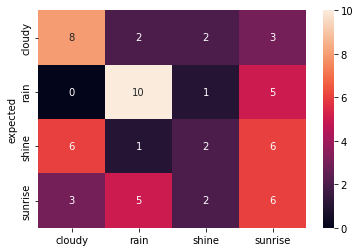

In [60]:
sns.heatmap(df_confusion, annot=True)